In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
from PIL import Image
import random
import csv

In [2]:
path = "/Volumes/Work/Mihir's Data/Machine Learning/COVID Classification/"
infectedImg_path = path + 'COVID'
healthyImg_path = path + 'non-COVID'

In [3]:
#Creating a CSV file since this dataset doesn't have one
fields = ['ImgName', 'Label']
filename = 'dataset.csv'
filepath = os.path.join(path, filename)
data = []
for i in os.listdir(infectedImg_path):
    if i[0] != '.':
        data.append([i, 1])

for i in os.listdir(healthyImg_path):
    if i[0] != '.':
        data.append([i, 0])

random.shuffle(data)

with open(filepath, 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(fields)
    csvwriter.writerows(data)

In [4]:
len(data)

3227

In [5]:
#Loading the dataset
df = pd.read_csv(filepath)

#Splitting it into test and train dataset
df['split'] = np.random.randn(df.shape[0], 1)
msk = np.random.rand(len(df)) <= 0.8

train_df = df[msk]
test_df = df[~msk]

In [12]:
train_df.head()

,ImgName,Label,split
0,577.png,0,1.200846
1,2020.02.22.20024927-p20-70%2.png,1,-0.621711
2,Covid (784).png,1,-0.875504
3,Non-Covid (30).png,0,-0.901180
4,Non-Covid (779).png,0,-0.946610


In [15]:
train_df.iloc[0, 1]

0

In [16]:
def test(dataFrame, root_dir, idx):
    label = dataFrame.iloc[idx, 1]
    if label == 0:
        newDir = os.path.join(root_dir, 'non-COVID')
    elif label == 1:
        newDir = os.path.join(root_dir, 'COVID')
    img_name = os.path.join(newDir, dataFrame.iloc[idx, 0])
    image = Image.open(img_name)
    
    return (image, label)

1


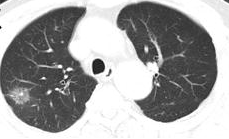

In [22]:
a,b = test(train_df, path, 1)
print(b)
a

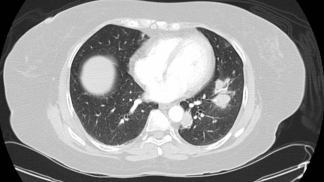

In [14]:
img = Image.open(os.path.join(healthyImg_path ,train_df.iloc[0,0]))
img

In [113]:
#Creating the container object for images and labels

class COVIDClassificationDataset(Dataset):
    def __init__(self, dataFrame, root_dir, transform = None):
        self.dataFrame = dataFrame
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataFrame)
    
    def __getitem__(self, idx):
        label = self.dataFrame.iloc[idx, 1]
        if label == 0:
            newDir = os.path.join(self.root_dir, 'non-COVID')
        elif label == 1:
            newDir = os.path.join(self.root_dir, 'COVID')
        img_name = os.path.join(newDir, self.dataFrame.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return (image, label)

In [142]:
img_transform = transforms.Compose([
    transforms.Resize(250),
    transforms.CenterCrop(227),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),


])

In [143]:
covid_train = COVIDClassificationDataset(dataFrame=train_df, root_dir= path, transform=img_transform)
covid_test = COVIDClassificationDataset(dataFrame=test_df, root_dir=path, transform=img_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


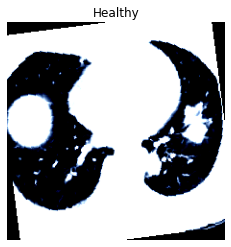

In [144]:
#Visualizing the image
import matplotlib.pyplot as plt

temp_img, temp_lab = covid_train[0]
plt.imshow(temp_img.numpy().transpose((1, 2, 0)))
if temp_lab:
    plt.title("Infected with COVID")
else:
    plt.title("Healthy")
plt.axis('off')
plt.show()

In [145]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [146]:
#Dataloader
train_loader = DataLoader(dataset=covid_train, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=covid_test, batch_size=16, shuffle=False)

In [147]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=2)


    def forward(self,x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.relu(out)
        out = self.conv4(out)
        out = self.relu(out)
        out = self.conv5(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)

        return out

In [148]:
model = AlexNet().to(device)

In [149]:
le = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = le)

In [150]:
num_ep = 1
n_steps = len(train_loader)
for ep in range(num_ep):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        #Forward Pass
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)

        #Backward Pass
        loss.backward()
        optimizer.step()
    
    print(f'Epoch: [{ep + 1} / {num_ep}], Loss: {loss.item():.4f}')

KeyboardInterrupt: 

In [ ]:
classes = {0, 1}

In [ ]:
with torch.no_grad():
    correct = 0
    samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        samples += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(16):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
    
    acc = 100 * correct / samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]} : {acc} %')